In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

<h2>PIPELINE:</h2>
<ol>
    <li>Load and prepare data<br></li>
    <br>
    <li>Design model (input, output size, forward pass)<br></li>
    <br>
    <li>Define loss and optimizer<br></li>
    <br>
    <li>Training loop:<br>
        1. forward pass: compute prediction<br>
        2. backward pass: gradients<br>
        3. update weights<br>
    </li>
    <br>
    <li>Evaluate the model on validation set<br></li>
    <br>
    <li>Try to predict something<br></li>
    <br>
</ol>

-------------------------------------------------------------------------

<h1>1. Load and prepare data</h1>

In [3]:
# Load data as pandas df
fin_data = pd.read_csv('./final_fin_df.csv')
fin_data.head(5)

,name,cik,filed,filed_year,year,period,"Entity Common Stock, Shares Outstanding",Entity Public Float,Accounts Payable (Deprecated 2009-01-31),"Accounts Receivable, after Allowance for Credit Loss, Current",...,Open,High,Low,Close,Avg_Price,open_movement,high_movement,low_movement,close_movement,avg_price_movement
0,A. O. Smith Corporation,91142,2010-08-04,2010,2010,2,0.0,0.0,0.0,0.0,...,0.001363,0.001641,0.001640,0.001640,0.001650,0,0,0,0,0
1,A. O. Smith Corporation,91142,2010-11-04,2010,2010,3,0.0,0.0,0.0,0.0,...,0.001662,0.001914,0.001915,0.001634,0.001811,1,1,1,0,1
2,A. O. Smith Corporation,91142,2011-05-10,2011,2011,1,0.0,0.0,0.0,0.0,...,0.001891,0.001873,0.002039,0.001761,0.002007,1,0,1,1,1
3,A. O. Smith Corporation,91142,2011-08-08,2011,2011,2,0.0,0.0,0.0,0.0,...,0.001807,0.001870,0.001746,0.001449,0.001788,0,0,0,0,0
4,A. O. Smith Corporation,91142,2011-11-08,2011,2011,3,0.0,0.0,0.0,0.0,...,0.001349,0.001715,0.001569,0.001698,0.001675,0,0,0,1,0


In [5]:
# Divide data into train/validation sets

# Split data (80/20)
train_split = fin_data[fin_data['year'] <= 2019]
valid_split = fin_data[(fin_data['year'] >= 2020) & (fin_data['year'] <= 2022)]

# Print count
all_ciks = fin_data['cik'].unique()
train_ciks = train_split['cik'].unique()
valid_ciks = valid_split['cik'].unique()

print(f'all data - shape{fin_data.shape}, CIKs = {len(all_ciks)}')
print(f'train data - shape{train_split.shape}, CIKs = {len(train_ciks)}')
print(f'validation data - shape{valid_split.shape}, CIKs = {len(valid_ciks)}')

all data - shape(183485, 1562), CIKs = 5639
train data - shape(124541, 1562), CIKs = 4153
validation data - shape(57928, 1562), CIKs = 5559


In [6]:
# Cut useless columns
columns_to_drop = ['name', 'filed', 'filed_year', 'year', 'period', 'Open', 'High', 'Low', 'Close', 'Avg_Price']
train_cropped = train_split.drop(columns_to_drop, axis=1)
valid_cropped = valid_split.drop(columns_to_drop, axis=1)

print(f'train_cropped = {train_cropped.shape}')
print(f'valid_cropped = {valid_cropped.shape}')

train_cropped = (124541, 1552)
dev_cropped = (57928, 1552)


In [7]:
# Every row from one company = 1 batch

# Initialize an empty lists to hold the batches
train_batches = []
valid_batches = []

# Group the df by 'cik'
train_grouped = train_cropped.groupby('cik')
valid_grouped = valid_cropped.groupby('cik')

# Iterate through each group and create batches
for _, group_data in train_grouped:
    # Drop the 'cik' column and reset the index
    train_batch = group_data.drop(columns=['cik']).reset_index(drop=True)
    # Reshape the batch to make it (1, m, n)
    train_batch = train_batch.values.reshape(1, -1, train_batch.shape[1])
    train_batches.append(train_batch)

# Do the same for validation set
for _, group_data in valid_grouped:
    valid_batch = group_data.drop(columns=['cik']).reset_index(drop=True)
    valid_batch = valid_batch.values.reshape(1, -1, valid_batch.shape[1])
    valid_batches.append(valid_batch)

# Check batches
for i, (train_batch, valid_batch) in enumerate(zip(train_batches, valid_batches)):
    print(f"batch_{i} shape =", train_batch.shape, '|', valid_batch.shape)

batch_0 shape = (1, 36, 1551) | (1, 12, 1551)
batch_1 shape = (1, 43, 1551) | (1, 11, 1551)
batch_2 shape = (1, 41, 1551) | (1, 11, 1551)
batch_3 shape = (1, 35, 1551) | (1, 11, 1551)
batch_4 shape = (1, 35, 1551) | (1, 11, 1551)
batch_5 shape = (1, 35, 1551) | (1, 11, 1551)
batch_6 shape = (1, 39, 1551) | (1, 11, 1551)
batch_7 shape = (1, 42, 1551) | (1, 12, 1551)
batch_8 shape = (1, 35, 1551) | (1, 11, 1551)
batch_9 shape = (1, 39, 1551) | (1, 11, 1551)
batch_10 shape = (1, 35, 1551) | (1, 11, 1551)
batch_11 shape = (1, 34, 1551) | (1, 12, 1551)
batch_12 shape = (1, 35, 1551) | (1, 11, 1551)
batch_13 shape = (1, 39, 1551) | (1, 12, 1551)
batch_14 shape = (1, 28, 1551) | (1, 22, 1551)
batch_15 shape = (1, 43, 1551) | (1, 11, 1551)
batch_16 shape = (1, 33, 1551) | (1, 11, 1551)
batch_17 shape = (1, 86, 1551) | (1, 22, 1551)
batch_18 shape = (1, 43, 1551) | (1, 11, 1551)
batch_19 shape = (1, 43, 1551) | (1, 11, 1551)
batch_20 shape = (1, 86, 1551) | (1, 22, 1551)
batch_21 shape = (1, 86

In [8]:
# Merge all batches

# Determine the maximum sequence length
train_max_seq_len = max(batch.shape[1] for batch in train_batches)
valid_max_seq_len = max(batch.shape[1] for batch in valid_batches)

# Create lists to hold X_train, y_train and X_valid, y_valid
X_train = []
y_train = []
X_valid = []
y_valid = []

# Iterate through the batches
for train_batch, valid_batch in zip(train_batches, valid_batches):
    
    # Extract the features and targets
    X_train_batch = train_batch[:, :, :-5]
    y_train_batch = train_batch[:, :, -5:]

    # Extract the features and targets
    X_valid_batch = valid_batch[:, :, :-5]
    y_valid_batch = valid_batch[:, :, -5:]

    # Pad sequences of train_batches to have the same length
    train_pad_size = train_max_seq_len - X_train_batch.shape[1]
    X_train_batch = np.pad(X_train_batch, ((0, 0), (0, train_pad_size), (0, 0)), 'constant')
    y_train_batch = np.pad(y_train_batch, ((0, 0), (0, train_pad_size), (0, 0)), 'constant')

    # Pad sequences of valid_batches to have the same length
    valid_pad_size = valid_max_seq_len - X_valid_batch.shape[1]
    X_valid_batch = np.pad(X_valid_batch, ((0, 0), (0, valid_pad_size), (0, 0)), 'constant')
    y_valid_batch = np.pad(y_valid_batch, ((0, 0), (0, valid_pad_size), (0, 0)), 'constant')

    # Append the sequences of train_batches
    X_train.append(X_train_batch)
    y_train.append(y_train_batch)

    # Append the sequences of valid_batches
    X_valid.append(X_valid_batch)
    y_valid.append(y_valid_batch)

# Convert the X_train, y_train to pytorch tensors
X_train = torch.tensor(np.vstack(X_train), dtype=torch.float32)
y_train = torch.tensor(np.vstack(y_train), dtype=torch.float32)

# Convert the X_valid, y_valid to pytorch tensors
X_valid = torch.tensor(np.vstack(X_valid), dtype=torch.float32)
y_valid = torch.tensor(np.vstack(y_valid), dtype=torch.float32)

# Check the shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: torch.Size([4153, 132, 1546])
y_train shape: torch.Size([4153, 132, 5])
X_valid shape: torch.Size([4153, 36, 1546])
y_valid shape: torch.Size([4153, 36, 5])


In [9]:
# Make torch DataLoader
batch_size = 32

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

valid_dataset = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [10]:
# Check DataLoader batches
for i, (train_batch, valid_batch) in enumerate(zip(train_loader, valid_loader)):
    x_train_batch, y_train_batch = train_batch
    x_valid_batch, y_valid_batch = valid_batch

    # make 1==1 to see train tenosrs, make 1==0 to see validation tenosrs
    if 1 == 1:
        print(f'train tensor {i+1}', '|', x_train_batch.shape, '|', y_train_batch.shape)
    else:
        print(f'validation tensor {i+1}', '|', x_valid_batch.shape, '|', y_valid_batch.shape)

train tensor 1 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 2 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 3 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 4 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 5 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 6 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 7 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 8 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 9 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 10 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 11 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 12 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 13 | torch.Size([32, 132, 1546]) | torch.Size([32, 132, 5])
train tensor 14 | torch.Size([32, 132, 1546]) | torch.Size([

<h1>2. Design model (input, output size, forward pass)</h1>

In [77]:
# Define hyperparmaters
input_size = X_train.shape[2]
output_size = y_train.shape[2]

hidden_size = 1250
num_layers = 3

num_epochs = 100
learning_rate = 0.0001

In [78]:
# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMClassifier, self).__init__()
        
        # Initializes the attributes for class instance
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Fully Connected linear layer
        self.fc = nn.Linear(hidden_size, output_size)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Creates a hidden state tensor filled with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Creates a cell state tensor filled with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Passes the input x through the LSTM layer with initial hidden and cell states to get the output tensor out
        # Underscore (_) represents the hidden and cell states of the LSTM at the last time step
        out, _ = self.lstm(x, (h0, c0))
        # Passes the output tensor through the fully connected linear layer
        out = self.fc(out)
        
        # sigmoid activation for binary classification
        out = self.sigmoid(out)

        return out

In [79]:
# Apply and check the model
model = LSTMClassifier(input_size, hidden_size, num_layers, output_size)
model.to(device)
print(model)

LSTMClassifier(
  (lstm): LSTM(1546, 1250, num_layers=3, batch_first=True)
  (fc): Linear(in_features=1250, out_features=5, bias=True)
  (sigmoid): Sigmoid()
)


<h1>3. Define loss and optimizer</h1>

In [80]:
# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

<h1>4. Training loop:</h1>

In [81]:
# Training loop
losses = []
for epoch in range(num_epochs):
    for features, targets in train_loader:

        # Move data to GPU
        features, targets = features.to(device), targets.to(device)

        # Forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Append the current loss to the list
    losses.append(loss.item())

    # Print the loss after each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 0.0243
Epoch [2/100], Loss: 0.0264
Epoch [3/100], Loss: 0.0213
Epoch [4/100], Loss: 0.0185
Epoch [5/100], Loss: 0.0164
Epoch [6/100], Loss: 0.0146
Epoch [7/100], Loss: 0.0133
Epoch [8/100], Loss: 0.0121
Epoch [9/100], Loss: 0.0111
Epoch [10/100], Loss: 0.0101
Epoch [11/100], Loss: 0.0089
Epoch [12/100], Loss: 0.0079
Epoch [13/100], Loss: 0.0078
Epoch [14/100], Loss: 0.0079
Epoch [15/100], Loss: 0.0084
Epoch [16/100], Loss: 0.0086
Epoch [17/100], Loss: 0.0088
Epoch [18/100], Loss: 0.0091
Epoch [19/100], Loss: 0.0092
Epoch [20/100], Loss: 0.0093
Epoch [21/100], Loss: 0.0094
Epoch [22/100], Loss: 0.0095
Epoch [23/100], Loss: 0.0095
Epoch [24/100], Loss: 0.0095
Epoch [25/100], Loss: 0.0095
Epoch [26/100], Loss: 0.0096
Epoch [27/100], Loss: 0.0096
Epoch [28/100], Loss: 0.0099
Epoch [29/100], Loss: 0.0100
Epoch [30/100], Loss: 0.0100
Epoch [31/100], Loss: 0.0102
Epoch [32/100], Loss: 0.0100
Epoch [33/100], Loss: 0.0101
Epoch [34/100], Loss: 0.0101
Epoch [35/100], Loss: 0

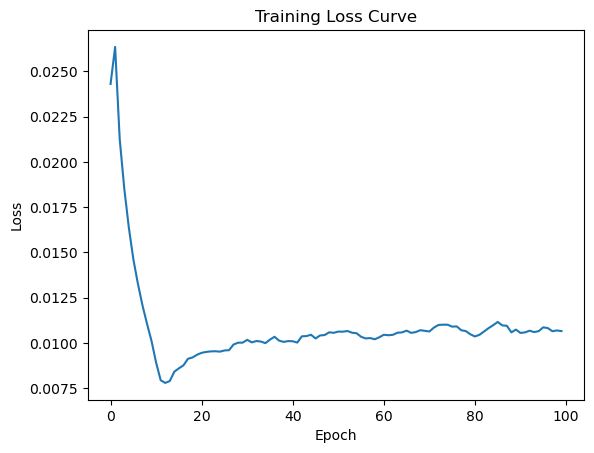

In [82]:
# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.show()

<h1>5. Evaluate the model on dev set:</h1>

In [83]:
# Define evaluation function
def evaluate(model, valid_loader, criterion, device):

    # Set the model to evaluation mode
    model.eval()

    total_loss = 0.0

    # Initialize a list with 0 with length 5 (output_size = 5)
    correct_predictions = [0] * output_size  
    total_samples = [0] * output_size
    # Initialize a list for each class (output_size = 5)
    true_labels = [[] for _ in range(output_size)]
    predicted_labels = [[] for _ in range(output_size)]

    # Evaluation loop
    with torch.no_grad():
        for features, targets in valid_loader:
            
            # Move data to GPU
            features, targets = features.to(device), targets.to(device)

            # Forward pass
            outputs = model(features)
            
            # Compute loss
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            
            # Threshold at 0.5 for binary classification
            predicted_labels_batch = (outputs > 0.5).float()
            
            # Loop through each class
            for i in range(output_size):
                
                # Check if the predicted label matches the target label for each element in the batch, and if they match, we increment the correct_predictions[i] value by 1
                correct_predictions[i] += ((predicted_labels_batch[:, :, i] == targets[:, :, i]).sum().item())
                # Calculate the total number of samples for the i-th output label
                total_samples[i] += targets[:, :, i].numel()
                
                # Make numpy arrays for true labels by extending with targets for index i
                true_labels[i].extend(targets[:, :, i].cpu().numpy().flatten())
                # Make numpy arrays for predicted labels by extending with predicted labels for index i
                predicted_labels[i].extend(predicted_labels_batch[:, :, i].cpu().numpy().flatten())

    # Calculate average loss and metrics for each class
    average_loss = total_loss / len(valid_loader)
    accuracy = [correct / total for correct, total in zip(correct_predictions, total_samples)]
    precision = [precision_score(true_labels[i], predicted_labels[i]) for i in range(output_size)]
    recall = [recall_score(true_labels[i], predicted_labels[i]) for i in range(output_size)]
    f1 = [f1_score(true_labels[i], predicted_labels[i]) for i in range(output_size)]

    return average_loss, accuracy, precision, recall, f1

In [84]:
# Evaluate the model on validation set
valid_loss, valid_accuracy, valid_precision, valid_recall, valid_f1 = evaluate(model, valid_loader, criterion, device)
print(f"Validation Loss: {valid_loss:.4f}")

for i in range(output_size):
    print(f"Class {i + 1} - Accuracy: {valid_accuracy[i]:.4f}, Precision: {valid_precision[i]:.4f}, Recall: {valid_recall[i]:.4f}, F1-score: {valid_f1[i]:.4f}")

Validation Loss: 0.2697
Class 1 - Accuracy: 0.8855, Precision: 0.6170, Recall: 0.6054, F1-score: 0.6111
Class 2 - Accuracy: 0.9046, Precision: 0.6952, Recall: 0.6368, F1-score: 0.6647
Class 3 - Accuracy: 0.9060, Precision: 0.7356, Recall: 0.6448, F1-score: 0.6872
Class 4 - Accuracy: 0.8988, Precision: 0.7018, Recall: 0.6183, F1-score: 0.6574
Class 5 - Accuracy: 0.9082, Precision: 0.7166, Recall: 0.6855, F1-score: 0.7007


<h1>6. Try to predict something</h1>

In [85]:
# Define a predict function
def predict(model, input_data, device):

    # Set the model to evaluation mode
    model.eval()  

    with torch.no_grad():

        # Move input data to the same device as the model
        input_data = input_data.to(device)
        # Forward pass to get predictions
        predictions = model(input_data)
        
    return predictions

In [86]:
# Try to predict stock prices for Apple company
apple_df = valid_split[valid_split['cik'] == 320193]
apple_df = apple_df.iloc[:, :-10]
apple_cropped = apple_df.drop(['name', 'cik', 'filed', 'filed_year', 'year', 'period'], axis=1)

apple_tensor = torch.tensor(apple_cropped.values, dtype=torch.float32)
# Add a batch dimension
apple_tensor = apple_tensor.unsqueeze(0)
print(apple_tensor.shape)

torch.Size([1, 12, 1546])


In [87]:
# See the predictions
predictions = predict(model, apple_tensor, device)
predictions = (predictions > 0.5).float()
predictions

tensor([[[0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [0., 1., 1., 1., 1.],
         [0., 1., 0., 0., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.],
         [0., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0.]]], device='cuda:0')